In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing all of the above

import os
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras.utils import to_categorical
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.interpolate import RegularGridInterpolator
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Defining root directories for Images and Masks

train_img_dir = "/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/input_data_128/train/masks/"

In [ ]:
# Collecting Data into NumPy arrays

images = []
masks = []

for file in os.listdir(train_img_dir):
    if (len(images) == 32):
        break
    images.append(np.load(train_img_dir + file))
    mask = np.load(train_mask_dir + "mask_" + file[6:])
    
    # Combining the 4 Different Scans available into 1.  
    mask = np.argmax(mask, axis=3)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [ ]:
images = np.array(images)
masks = np.array(masks)

In [ ]:
# Understanding Dimensions of Data

print("Shape of Images Data : ", images.shape)
print("Shape of Classification Labels corresponding to them : ", masks.shape)

Shape of Images Data :  (32, 128, 128, 128, 3)
Shape of Classification Labels corresponding to them :  (32, 128, 128, 128)


In [ ]:
images = images[:16]
masks = masks[:16]

In [ ]:
# Define a regrid() function, that helps in resizing an image
# based on interpolation of pixels.

def regrid(data, out_x, out_y):
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

In [ ]:
# Due to limited computation resources, we minimize the size
# of each image in the 3D Volume from 256 x 256 to 64 x 64.

minimized_size = 64

small_images = []
small_masks = []

for i in range(0, len(images)):
    image = images[i]
    mask = masks[i]
    curr_image = []
    curr_mask = []
    
    for z in range(0, 128):
        image_z_0 = image[:, :, z, 0]
        image_z_1 = image[:, :, z, 1]
        image_z_2 = image[:, :, z, 2]
        image_z_0 = regrid(image_z_0, minimized_size, minimized_size)
        image_z_1 = regrid(image_z_1, minimized_size, minimized_size)
        image_z_2 = regrid(image_z_2, minimized_size, minimized_size)
        curr_depth = np.stack([image_z_0, image_z_1, image_z_2])
        curr_depth = np.moveaxis(curr_depth, -1, 0)
        curr_depth = np.moveaxis(curr_depth, -1, 0)
        curr_image.append(curr_depth)
        mask_z = mask[:, :, z]
        mask_z = np.array(np.round(regrid(mask_z, minimized_size, minimized_size)), dtype = 'uint8')
        curr_mask.append(mask_z)
    
    small_images.append(np.array(curr_image))
    small_masks.append(np.array(curr_mask))

small_images = np.array(small_images)
small_masks = np.array(small_masks)

In [ ]:
# Understanding Dimensions of Processed Data

print("Shape of Images Data : ", small_images.shape)
print("Shape of Classification Labels corresponding to them : ", small_masks.shape)

Shape of Images Data :  (32, 128, 64, 64, 3)
Shape of Classification Labels corresponding to them :  (32, 128, 64, 64)


In [ ]:
# Dividing Processed Scans into Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (small_images,
                                                     small_masks,
                                                     test_size=0.2,
                                                     shuffle=True)

In [ ]:
y_train_cat = to_categorical(y_train, num_classes = 3)
y_test_cat = to_categorical(y_test, num_classes = 3)

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)
        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers


class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 64, 64), input_dim=3, output_dim=4, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )
      
    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        #sigmoidLayer = torch.nn.Sigmoid()
        #output = torch.round(sigmoidLayer(output))
        return output

In [ ]:
model = UNETR()

In [ ]:
X_train = X_train.reshape((-1, 3, 128, 64, 64))
y_train = y_train.reshape((-1, 128, 64, 64))

In [ ]:
X_test = X_test.reshape((-1, 3, 128, 64, 64))
y_test = y_test.reshape((-1, 128, 64, 64))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
tensor_x = torch.Tensor(X_train)
tensor_y = torch.Tensor(y_train)
tensor_y = tensor_y.type(torch.LongTensor)

tensor_test_x = torch.Tensor(X_test)
tensor_test_y = torch.Tensor(y_test)
tensor_test_y = tensor_test_y.type(torch.LongTensor)

In [ ]:
my_dataset = TensorDataset(tensor_x,tensor_y)
my_dataloader = DataLoader(my_dataset)

my_dataset_test = TensorDataset(tensor_test_x,tensor_test_y)
my_dataloader_test = DataLoader(my_dataset_test)

In [ ]:
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [ ]:
model = UNETR()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/swin_model_weights_705.pth'))

<All keys matched successfully>

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred = y_pred[:, 0, :, :, :] + y_pred[:, 1, :, :, :] + y_pred[:, 2, :, :, :] + y_pred[:, 3, :, :, :]
    y_pred = torch.round(torch.sigmoid(y_pred) * 3)
    y_pred = torch.flatten(y_pred)
    y_test = torch.flatten(y_test)
    correct_pred = (y_pred == y_test).float()
    acc = correct_pred.sum() / len(y_pred)
    return acc

In [ ]:
def IoU(y_pred, y_test):
    y_pred = y_pred[:, 0, :, :, :] + y_pred[:, 1, :, :, :] + y_pred[:, 2, :, :, :] + y_pred[:, 3, :, :, :]
    y_pred = torch.flatten(y_pred).cpu().detach().numpy()
    y_test = torch.flatten(y_test).cpu().detach().numpy()
    y_pred = np.around(3.0/(1 + np.exp(-y_pred)))
    print(y_pred.shape)
    print(y_test.shape)
    print(np.unique(y_pred))
    print(np.unique(y_test))
    inter = 0
    union = 0
    for i in range(0, len(y_pred)):
        if (y_pred[i] == y_test[i] and y_pred[i] != 0):
            inter += 1
            union += 1
        elif (y_pred[i] + y_test[i] >= 1):
            union += 1
    return inter * 1.0 / union

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model = model.cuda()

In [ ]:
model = UNETR()

In [ ]:
for e in tqdm(range(1, 100+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0 
    
    model.train()
    batch_num = 0

    for X_train_batch, y_train_batch in my_dataloader:
        batch_num += 1
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        IoU_acc = IoU(y_train_pred, y_train_batch)
        print("Epoch : ", e, "| Batch ", batch_num, "| Loss : ", round(train_loss.item(), 3), "| Accuracy : ", round(train_acc.item(), 6), "| IoU : ", round(IoU_acc, 6))

        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model_weights_' + str(e + 600) + '.pth')    
 
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in my_dataloader_test:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            IoU_acc = IoU(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item() 
            print("Epoch : ", e, "| Batch ", batch_num, "| Loss : ", round(val_loss.item(), 3), "| Accuracy : ", round(val_acc.item(), 6), "| IoU : ", round(IoU_acc, 6))
                      
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(my_dataloader):.5f} | Train Acc: {train_epoch_acc/len(my_dataloader):.3f}')
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(my_dataloader):.5f} | Val Loss: {val_epoch_loss/len(my_dataloader_test):.5f} | Train Acc: {train_epoch_acc/len(my_dataloader):.3f}| Val Acc: {val_epoch_acc/len(my_dataloader_test):.3f}')

In [ ]:
test_images = np.load("/content/drive/MyDrive/test_set.npy")
test_masks = np.load("/content/drive/MyDrive/test_set_masks.npy")

In [ ]:
print(test_images.shape)
print(test_masks.shape)

(5, 128, 64, 64, 3)
(5, 128, 64, 64)


In [ ]:
small_test_images = test_images.reshape((-1, 3, 128, 64, 64))
small_test_masks = test_masks.reshape((-1, 128, 64, 64))

In [ ]:
tensor_test_x = torch.Tensor(small_test_images)
tensor_test_y = torch.Tensor(small_test_masks)
tensor_test_y = tensor_test_y.type(torch.LongTensor)

In [ ]:
my_test_dataset = TensorDataset(tensor_test_x,tensor_test_y)
my_test_dataloader = DataLoader(my_test_dataset)

In [ ]:
print("Testing ... ")
batch_num = 0
for_saving_pred = []
for_saving_act = []
for X_train_batch, y_train_batch in my_test_dataloader:
    batch_num += 1
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
    y_train_pred = model(X_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    for_saving_pred.append(y_train_pred.detach().cpu().numpy())
    for_saving_act.append(y_train_batch.detach().cpu().numpy())
    #print("Batch ", batch_num, "| Accuracy : ", round(train_acc.item(), 3))

Testing ... 


In [ ]:
for_saving_pred = np.array(for_saving_pred)
for_saving_act = np.array(for_saving_act)

In [ ]:
for_saving_pred = for_saving_pred[:, :, 0, :, :, :] + for_saving_pred[:, :, 1, :, :, :] + for_saving_pred[:, :, 2, :, :, :] + for_saving_pred[:, :, 3, :, :, :]
for_saving_pred = np.around(6.0/(1 + np.exp(-for_saving_pred)))

In [ ]:
np.unique(for_saving_pred)

array([0., 1., 2., 3.], dtype=float32)

In [ ]:
predictions = np.load("/content/drive/MyDrive/predictions.npy")
predictions = np.argmax(predictions, axis = 4)

Qualitative Results Obtained


Text(0.5, 1.0, 'True Classification')

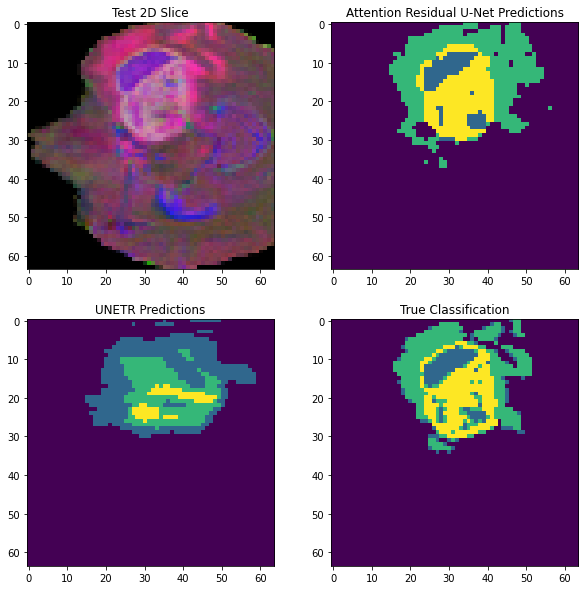

In [ ]:
print("Qualitative Results Obtained")
fig, axarr = plt.subplots(2,2)
fig.set_size_inches(10, 10)
axarr[0,0].imshow(test_images[0][43])
axarr[0,0].set_title('Test 2D Slice')
axarr[0,1].imshow(predictions[0, 43])
axarr[0,1].set_title('Attention Residual U-Net Predictions')
axarr[1,0].imshow(for_saving_pred[0, 0, 43])
axarr[1,0].set_title('UNETR Predictions')
axarr[1,1].imshow(for_saving_act[0, 0, 43])
axarr[1,1].set_title('True Classification')

In [ ]:
test_images_flattened = test_images.flatten()
attn_predictions_flattened = predictions.flatten()
unetr_predictions_flattened = for_saving_pred.flatten()
true_flattened = for_saving_act.flatten()

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
pytorch_total_params

152593284

In [ ]:
152,593,284

In [ ]:
key = 1
inter_attn = 0.0
union_attn = 0.0
for i in range(0, len(true_flattened)):
    if (true_flattened[i] == key):
        if (true_flattened[i] == attn_predictions_flattened[i]):
            inter_attn += 1
        union_attn += 1
inter_attn/union_attn

0.27930424914340585

In [ ]:
key = 3
inter_attn = 0.0
union_attn = 0.0
for i in range(0, len(true_flattened)):
    if (true_flattened[i] == key):
        if (true_flattened[i] == unetr_predictions_flattened[i]):
            inter_attn += 1
        union_attn += 1
inter_attn/union_attn

0.06101373756513501